## Sección de Librerías

In [1]:
#Básicos para manipulacion de datos 
import pandas as pd
import numpy as np
#Graficas 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
sns.set_theme()
#Optimización multiobjetivo 
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.core.population import Population

#Finanzas 
import yfinance as yf
import yesg

#Plugins
from tqdm import tqdm
from itertools import compress
from Plugins import pre_processing
from Plugins import ArchievingStrategies
from Plugins import my_plotting
from Plugins import pymoo_extras

## Descarga de lista de activos a escoger
Esta sección puede dar errores si se pierde la conexión, solo es necesario volver a ejecutar. 

In [2]:
assets = pd.read_csv('Indices/tickers_dowjones.csv', index_col=0)['0'].tolist()

## Primera parte, obtención de los activos para el portafolio

In [3]:
ohlc = yf.download(assets, period="2y") 
prices = ohlc["Adj Close"].dropna(how="all")

[*********************100%***********************]  30 of 30 completed


In [4]:
prices.tail()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,DOW,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
Date,,,,,,,,,,,,,,,,,,,,,
2023-06-22,187.000000,229.660004,168.259995,205.610001,237.339996,213.289993,51.119999,152.639999,88.489998,51.389999,...,113.720001,339.709991,110.459999,149.949997,175.009995,479.049988,228.389999,35.849998,31.889999,155.750000
2023-06-23,186.679993,227.110001,168.070007,205.410004,234.440002,210.089996,50.330002,151.350006,88.099998,51.360001,...,114.599998,335.019989,109.519997,148.460007,173.720001,477.000000,229.550003,35.509998,31.400000,155.460007
2023-06-26,185.270004,224.729996,167.110001,205.580002,236.949997,207.360001,50.209999,154.009995,88.699997,51.950001,...,113.080002,328.600006,111.739998,148.610001,172.389999,479.059998,226.300003,36.110001,31.590000,155.050003
2023-06-27,188.059998,222.610001,168.190002,209.429993,240.690002,208.820007,50.860001,153.529999,89.059998,52.570000,...,113.320000,334.570007,113.610001,150.020004,172.589996,482.559998,227.339996,36.549999,28.639999,154.490005
2023-06-28,188.720001,220.570007,168.720001,210.494995,241.070007,210.160004,50.785000,154.330002,88.845001,52.529999,...,112.978897,335.359985,112.699997,150.149994,168.824997,477.420013,227.020004,36.580002,28.347500,155.380005


In [5]:
returns, assets_info= pre_processing.get_assets_info(prices, 99, log_returns=True, drop_per_esg=True)
assets_info #Los rendimientos están con signo al revés 

100%|██████████| 30/30 [00:04<00:00,  6.03it/s]


,exp_risk,exp_return,esg_score
AAPL,0.296361,-0.174482,0.167
VZ,0.199426,0.160706,0.185
V,0.266551,0.008069,0.161
UNH,0.228811,-0.100412,0.175
TRV,0.224957,-0.082831,0.205
PG,0.184789,-0.076883,0.266
NKE,0.344317,0.140906,0.170
MSFT,0.303920,-0.119881,0.152
MRK,0.221032,-0.224850,0.218
MMM,0.254622,0.304338,0.336


In [6]:
best_assets = ArchievingStrategies.get_best_opt(assets_info.iloc[:, :2], 1e-6)
best_assets

29it [00:00, 14523.56it/s]


,exp_risk,exp_return
MRK,0.221032,-0.224850
MCD,0.172449,-0.138197
KO,0.169045,-0.086434
JNJ,0.160042,-0.023125
CVX,0.283827,-0.237279


In [7]:
fig = my_plotting.plot_assets_plotly(assets_info, best_assets)

## Segunda Parte, Definición del Problema

In [8]:
PROFITS, RISK, ESG_SCORES = pre_processing.get_final_assets(returns[best_assets.index])
portfolio_problem = pymoo_extras.Portfolio_Problem(len(PROFITS), PROFITS, RISK, ESG_SCORES)

100%|██████████| 5/5 [00:00<00:00,  7.39it/s]


In [9]:
from finquant import efficient_frontier
ef = efficient_frontier.EfficientFrontier(pd.Series(PROFITS), pd.DataFrame(RISK), freq=252)
ef_R = ef.efficient_frontier()

## Tercera parte, utilizar distintos muestreos

In [10]:
eps = np.array([0.01,0.01])
colors = ['#7F7F7F', 'rgb(141,160,203)', 'rgb(27,158, 119)']

### Con pesos uniformes

In [11]:
X_das = get_reference_directions("das-dennis", len(PROFITS), n_partitions=17)
F_das, ESG_das = pymoo_extras.eval_weights(portfolio_problem, X_das)
FA_das =  pymoo_extras.annualised_portfolio_quantities(F_das)
FA_das_best = ArchievingStrategies.get_best_opt(FA_das, 1e-6)
FA_das_best_eps = ArchievingStrategies.get_best_opt_eps(FA_das, 1e-6, eps)
print('Total', FA_das.shape)
print('Mejores', FA_das_best.shape)
print('Eps-Mejores', FA_das_best_eps.shape)


5985it [00:00, 21074.20it/s]
5985it [00:02, 2385.15it/s]

Total (5985, 2)
Mejores (84, 2)
Eps-Mejores (3512, 2)


In [12]:
frames = [FA_das, FA_das_best_eps, FA_das_best]
labels = ['All (Das-Dennis)', 'PQ-eps', 'PQ']
fig = my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)

### Con Algoritmos Evolutivos

In [13]:
from pymoo.termination import get_termination
termination = get_termination("n_gen", 300)
from pymoo.algorithms.moo.nsga2 import NSGA2
nsgaii = NSGA2(pop_size=20,repair=pymoo_extras.Portfolio_Repair())
from pymoo.algorithms.moo.sms import SMSEMOA
smsemoa = SMSEMOA(pop_size=20, repair=pymoo_extras.Portfolio_Repair())

#### Con NSGA-II

In [14]:
X_nsgaii, F_nsgaii, ESG_nsgaii =pymoo_extras.get_weights_with_pymoo(portfolio_problem, nsgaii, termination)
FA_nsgaii =  pymoo_extras.annualised_portfolio_quantities(F_nsgaii)
FA_nsgaii_best = ArchievingStrategies.get_best_opt(FA_nsgaii, 1e-6)
FA_nsgaii_best_eps = ArchievingStrategies.get_best_opt_eps(FA_nsgaii, 1e-6, eps)
print('Total', FA_nsgaii.shape)
print('Mejores', FA_nsgaii_best.shape)
print('Eps-Mejores', FA_nsgaii_best_eps.shape)

6000it [00:00, 14814.72it/s]
6000it [00:03, 1693.75it/s]

Total (6000, 2)
Mejores (691, 2)
Eps-Mejores (5319, 2)


In [15]:
frames = [FA_nsgaii, FA_nsgaii_best_eps, FA_nsgaii_best]
labels = ['All (NSGA-II)', 'PQ-eps', 'PQ']
fig=my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)

#### Con SMS-EMOA

In [16]:
X_smsemoa, F_smsemoa, ESG_smsemoa =pymoo_extras.get_weights_with_pymoo(portfolio_problem, smsemoa, termination)
FA_smsemoa =  pymoo_extras.annualised_portfolio_quantities(F_smsemoa)
FA_smsemoa_best = ArchievingStrategies.get_best_opt(FA_smsemoa, 1e-6)
FA_smsemoa_best_eps = ArchievingStrategies.get_best_opt_eps(FA_smsemoa, 1e-6, eps)
print('Total', FA_smsemoa.shape)
print('Mejores', FA_smsemoa_best.shape)
print('Eps-Mejores', FA_smsemoa_best_eps.shape)

6000it [00:00, 10344.71it/s]
6000it [00:04, 1494.02it/s]

Total (6000, 2)
Mejores (1251, 2)
Eps-Mejores (5653, 2)


In [17]:
frames = [FA_smsemoa, FA_smsemoa_best_eps, FA_smsemoa_best]
labels = ['All (SMS-EMOA)', 'PQ-eps', 'PQ']
fig=my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)

## Evaluación 

In [18]:
from pymoo.indicators.hv import HV
from pymoo.indicators.igd import IGD
from pymoo.indicators.gd import GD
from sklearn.preprocessing import MinMaxScaler
def get_pfa(name,  parameter): 
    if name=='das-dennis':
        X_ = get_reference_directions("das-dennis", len(PROFITS), n_partitions=parameter)
        F_, ESG_ = pymoo_extras.eval_weights(portfolio_problem, X_das)
    else: 
        X_, F_, ESG_ =pymoo_extras.get_weights_with_pymoo(portfolio_problem, parameter, termination)
    FA_ = pymoo_extras.annualised_portfolio_quantities(F_)
    FA_best = ArchievingStrategies.get_best_opt(FA_, 1e-6)
    return FA_best.to_numpy()

def invert_sign(list_pfa): 
    L = []
    for s in list_pfa:
        s1 = s.copy()
        s1[:, 1] = -s1[:,1]
        L.append(s1)   
    return L  

def eval_GD(pf, list_pfa):  
    ind = GD(pf)
    list_p = invert_sign(list_pfa)
    return [ind(A) for A in list_p]   

def eval_IGD(pf, list_pfa): 
    ind = IGD(pf)
    list_p = invert_sign(list_pfa)
    return [ind(A) for A in list_p]  

def eval_HV(ref_point, list_pfa): 
    scaler = MinMaxScaler()
    Ftest = np.vstack(list_pfa)
    scaler.fit(Ftest)
    ind = HV(ref_point=ref_point)
    return [ind(scaler.transform(A)) for A in list_pfa]

algs = { 'das-dennis': 12, 'nsgaii': nsgaii, 'sms-emoa':smsemoa}

def full_evaluation(iters, algs, pf, ref_point):
    metric_eval = {'GD': [], 'IGD': [], 'HV': []}
    metrics = {'GD': lambda x: eval_GD(pf, x), 
               'IGD':lambda x: eval_IGD(pf, x), 
               'HV': lambda x: eval_HV(ref_point, x)}
    for i in range(iters): 
        results = [ get_pfa(name, par) for name, par in algs.items()]
        for indicator in metrics.keys(): 
            metric_eval[indicator].append(metrics[indicator](results[:]))
    
    metric_eval_means = {}
    for indicator in metric_eval.keys(): 
        metric_eval_means[indicator]=np.mean( np.array(metric_eval[indicator]), axis=0)
    
    return pd.DataFrame(metric_eval_means, index = algs.keys())
     


In [19]:
evaluation = full_evaluation(10, algs, ef_R, np.array([1.1,1.1]))
evaluation

5985it [00:00, 16992.36it/s]
6000it [00:00, 13442.19it/s]
6000it [00:00, 9898.52it/s] 
5985it [00:00, 21606.99it/s]
6000it [00:00, 15936.19it/s]
6000it [00:00, 10325.61it/s]
5985it [00:00, 24527.02it/s]
6000it [00:00, 13818.01it/s]
6000it [00:00, 10389.90it/s]
5985it [00:00, 23088.36it/s]
6000it [00:00, 15166.36it/s]
6000it [00:00, 9510.56it/s] 
5985it [00:00, 24210.95it/s]
6000it [00:00, 16172.38it/s]
6000it [00:00, 10133.67it/s]
5985it [00:00, 24833.39it/s]
6000it [00:00, 15220.93it/s]
6000it [00:00, 9534.08it/s] 
5985it [00:00, 23844.40it/s]
6000it [00:00, 14543.03it/s]
6000it [00:00, 9463.82it/s] 
5985it [00:00, 22248.63it/s]
6000it [00:00, 13742.65it/s]
6000it [00:00, 9950.21it/s] 
5985it [00:00, 22084.37it/s]
6000it [00:00, 13320.14it/s]
6000it [00:00, 9475.92it/s] 
5985it [00:00, 23749.72it/s]
6000it [00:00, 15105.50it/s]
6000it [00:00, 9855.43it/s] 


,GD,IGD,HV
das-dennis,0.001683,0.014762,1.076387
nsgaii,0.004137,0.016675,1.082216
sms-emoa,0.001783,0.016745,1.082883


## Gráficas de Interés Muestreo Ganador

In [20]:
X, F, ESG =pymoo_extras.get_weights_with_pymoo(portfolio_problem,smsemoa, termination)
FA =  pymoo_extras.annualised_portfolio_quantities(F)
FA_best = ArchievingStrategies.get_best_opt(FA, 1e-6)
FA_best_eps = ArchievingStrategies.get_best_opt_eps(FA, 1e-6, eps)

FA_3D = FA_best_eps.copy()
FA_3D['exp_esg'] = ESG[FA_best_eps.index]
FA_3D_best       = ArchievingStrategies.get_best_opt(FA_3D, 1e-6)

print('Total', FA.shape)
print('Mejores', FA_best.shape)
print('Eps-Mejores', FA_best_eps.shape)
print('Mejores 3D', FA_3D_best.shape)

6000it [00:00, 8866.96it/s] 
6000it [00:04, 1373.07it/s]
5735it [00:01, 4312.59it/s]

Total (6000, 2)
Mejores (1308, 2)
Eps-Mejores (5735, 2)
Mejores 3D (2256, 3)


In [21]:
frames = [FA, FA_best_eps, FA_best]
labels = ['All (SMS-EMOA)', 'PQ-eps', 'PQ']
colors = ['#7F7F7F', 'rgb(141,160,203)', 'rgb(27,158, 119)']
fig = my_plotting.plotting_samples_plotly(ef_R, frames, labels, colors)

In [22]:
## Correciones de signos 
#En dos objetivos
FA_best['exp_return'] = -FA_best['exp_return']
FA_best['exp_esg'] =  ESG[FA_best.index] 
#En tres objetivos
FA_3D_best['exp_return'] = - FA_3D_best['exp_return']
FA_3D['exp_return'] = - FA_3D['exp_return']
FA_3D['Type'] = 'PQ-eps 2obj'
FA_3D.loc[FA_3D_best.index, 'Type']='PQ 3obj'

In [23]:
fig = px.scatter_3d(FA_3D.sort_values(by='Type'), x='exp_risk', y='exp_return', z='exp_esg',
                color_discrete_sequence=['rgb(27,158, 119)','rgb(141,160,203)'],
                color='Type', width=800, height=800, 
                labels = {'exp_risk':'Riesgo Anual Esperado', 
                          'exp_return': 'Retorno Anual Esperado', 
                          'exp_esg': 'ESG score'})
fig.update_layout(
    margin=dict(l=20, r=20, t=20, b=20),
)
fig.show()

In [24]:
fig = px.scatter(FA_3D_best, x='exp_risk', y='exp_return', color='exp_esg',
                 labels = {'exp_risk':'Riesgo Anual Esperado', 
                          'exp_return': 'Retorno Anual Esperado', 
                          'exp_esg': 'ESG score'})
fig.add_trace(go.Scatter(x=ef_R[:,0], y=ef_R[:,1],
                    mode='lines',
                    name='Markowitz', 
                    marker_color='#222A2A'), 
                 )
fig.update_layout(coloraxis_colorbar_y=0.45)
fig.show()

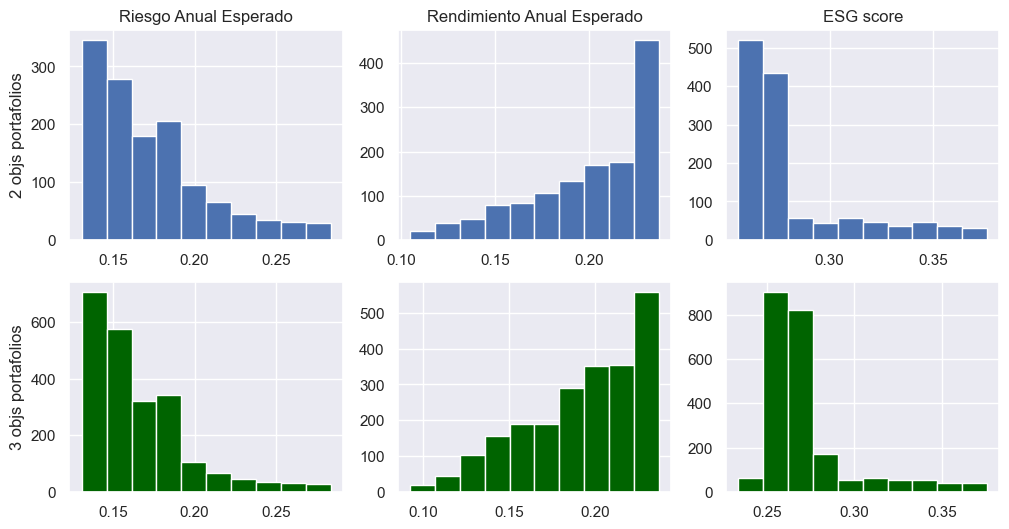

In [25]:
fig, ax = plt.subplots(2,3, figsize= (12,6))
ax[0][0].set_ylabel('2 objs portafolios')
ax[1][0].set_ylabel('3 objs portafolios')
ax[0][0].set_title('Riesgo Anual Esperado')
ax[0][1].set_title('Rendimiento Anual Esperado')
ax[0][2].set_title('ESG score')
for i in range(3): 
    FA_best.iloc[:, i].hist(ax=ax[0][i])
    FA_3D_best.iloc[:, i].hist(ax=ax[1][i], color='darkgreen')


In [26]:
X_best = X[FA_best.index]
X_3D_best = X[FA_3D_best.index]
X_best_means = np.mean(X_best, axis=0)
X_3D_best_means = np.mean(X_3D_best, axis=0)


In [27]:
assets_proportion = assets_info.loc[best_assets.index]
assets_proportion['Aportación 2obj']= X_best_means 
assets_proportion['Aportación 3obj']= X_3D_best_means

Text(0.5, 1.0, 'Composición de Portafolios 3 objs')

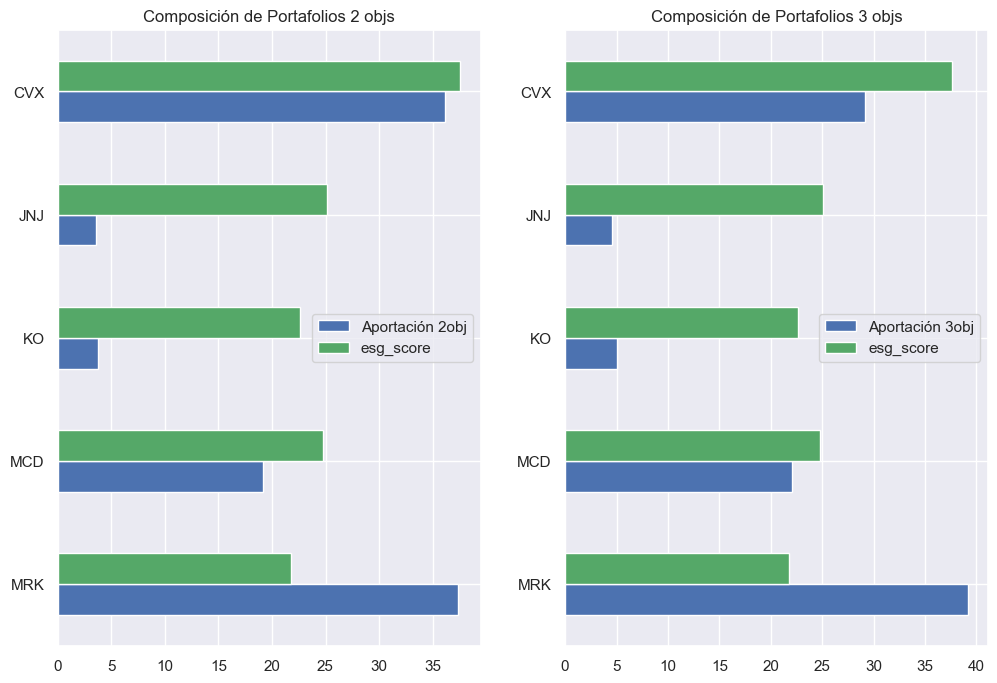

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(12,8))
(assets_proportion[['Aportación 2obj','esg_score']]*100).plot(kind='barh', ax=ax[0])
(assets_proportion[['Aportación 3obj','esg_score']]*100).plot(kind='barh', ax=ax[1])
ax[0].set_title('Composición de Portafolios 2 objs')
ax[1].set_title('Composición de Portafolios 3 objs')